In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('functions/')
from read_file import read_file
from filebrowser import FileBrowser

%matplotlib notebook

## File browser:

In [21]:
from filebrowser import FileBrowser
File = FileBrowser()
display(File.widget())

path = File.path

In [22]:
def get_SNR(f, window = 11, plot = False):
    """awdawd"""
    from scipy.signal import savgol_filter
    
    f_s = savgol_filter(f, window, 2)
    
    def process(f):
        
        F = np.asarray(f)
        if F[0] > F[-1]:
            F = F - min(F)
        else:
            F = F - max(F)
        F = F
        
        F = np.abs(F)
        F = F + np.average(F)*2
        
        return f
    
    #f = process(f)
    
    SNR = f_s/np.abs(f-f_s)
    SNR_ave = np.average(SNR[20:], weights = (1/SNR[20:])**2)
    if plot:
        fig = plt.figure()
        ay  = fig.add_subplot(211)
        ay.plot(f, label = 'Original')
        ay.plot(f_s, label = 'Smoothed')
        ax  = fig.add_subplot(212)
        ax.set_yscale('log')
        ax.plot(SNR, 'x')
        ax.axhline(SNR_ave, c = 'r')
        
    return SNR_ave

In [23]:
def draw_SNR(df, window = 31):
    """awdawd"""
    s = []
    F = 0
    count = 0
    
    for i, col in df.iteritems():
        F = F + col
        count = count + 1
        if count >= stop:
            break
        s.append(get_SNR(F/count, window))
    return np.asarray(s)

In [24]:
def average_spectra(path, dT = 0.3, save = False):
    '''Function to average captured Laplace DLTS spectra
    path – path to file to precess
    save – True for saving final data
     
    '''
    
    from scipy.optimize import curve_fit
    
    def sqrt(x, a):
        return a*np.sqrt(x)

    def cluster_T(T, dT):
        """Cluster Temperature array
        T – initial array
        
        T_av – clustered data
        
        """
        T_cl = [T[0]]
        for i, _T in enumerate(T):
            if i != 0:
                if np.abs(T[i] - T[i-1]) >= dT:
                    T_cl.append(T[i])

        T_cl = np.array(T_cl)
        
        T_av = []
        for i, _Tc in enumerate(T_cl):
            temp  = 0
            count = 0
            for j, _T in enumerate(T):
                if np.abs(_Tc - _T) < dT:
                    temp  = temp  + _T
                    count = count + 1
            T_av.append(temp/count)
                    
        return np.array(T_av)
    
    def average_columns(df, T_av, dT):
        '''Averaging tra'''
        
        data = []
        for i, _T in enumerate(T_av):
            temp  = 0
            count = 0
            for i, col in df.iteritems():
                if np.abs(_T - i) < dT:
                    temp  = temp  + col
                    count = count + 1
            data.append(temp/count)
            
        data = np.array(data)
        return pd.DataFrame(data.T, columns = T_av)
    
    def save_spectra(df, save):
        T = np.asmatrix(df.columns)
        C = np.asmatrix(df)
        
        if save:
            
            #data = np.append(T.T, C.T, axis = 1)
            Z = np.zeros(T.T.shape)
            #print(Z.shape)
            data = np.append(T.T,    Z, axis = 1)
            data = np.append(data, C.T, axis = 1)
            data = np.append(data,   Z, axis = 1)
            data = np.append(data,   Z, axis = 1)
            #print(data)
            np.savetxt('data/averaged/averaged.DLTS', data, fmt='%.28e', delimiter='\t')
        
        return df2   
    
    
    t, C, T = read_file(path)
    print('Tolal transients %.0f'%len(C))
    
    
    df = pd.DataFrame(C.T, columns = T)
    df = df.sort_index(axis=1)

    # Clustering temperature
    T_av = cluster_T(df.columns, dT)
    
    # Averaging transienst
    df2 = average_columns(df, T_av, dT)
    
    # Saving averaged data
    save_spectra(df2, save)
    
    #display(df)
    #display(df2)
    fig = plt.figure(figsize = (5,10))
    ax1 = fig.add_subplot(211)
    ax1.set_xscale('log')
    
    ax1.plot(df, c = 'k', lw = 0.2)
    for i, col in df2.iteritems():
        ax1.plot(col, lw = 2, label = '%.2f K'%i)
    ax1.legend()
    
    ax2 = fig.add_subplot(212) 
    SNR = draw_SNR(df, window = 31)
    n = np.linspace(1, len(SNR), len(SNR))
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.plot(n, SNR, 'o', label = 'SNR')
    popt, pcov = curve_fit(sqrt, n, SNR, p0 = 100)
    ax2.plot(n, sqrt(n, *popt), label = 'fit')
    initial = df.iloc[:,0]
    print('SNR for initial transiens is %.1e'%get_SNR(initial, window = 31, plot = True))

Tolal transients 294


<IPython.core.display.Javascript object>


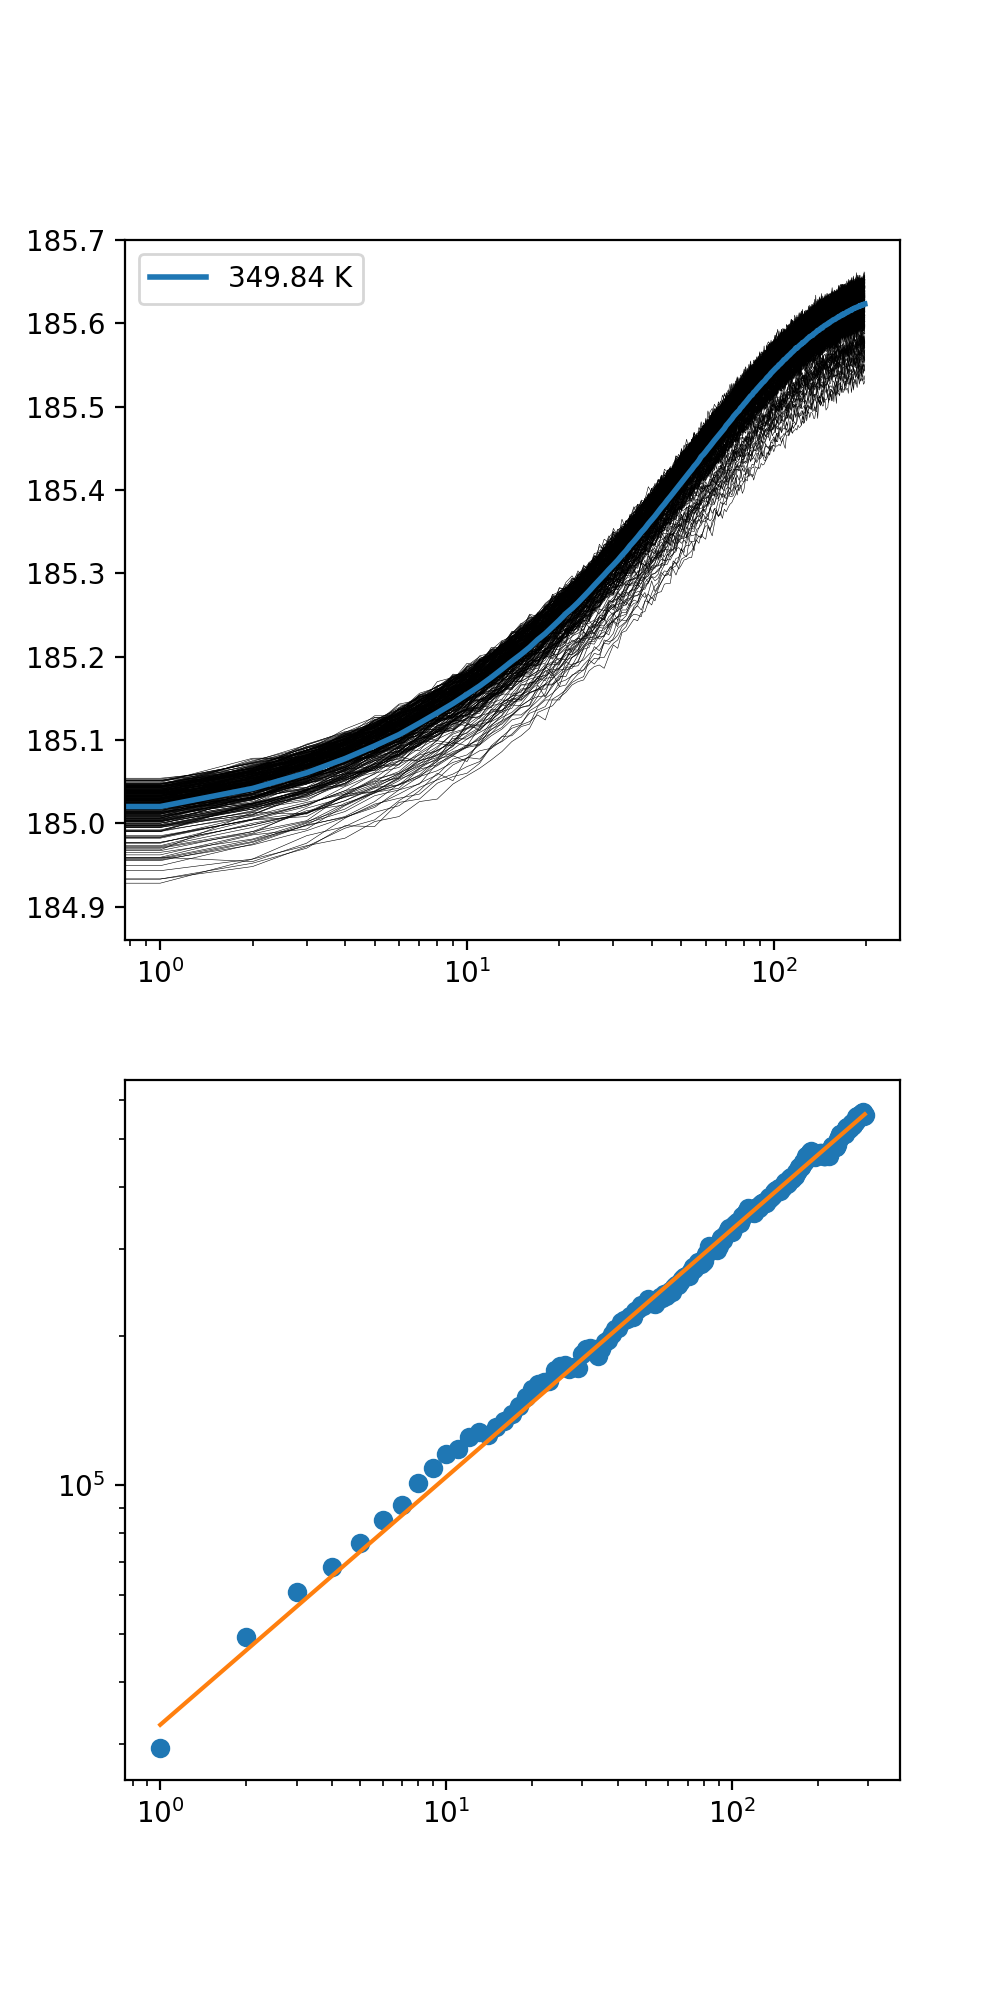

<IPython.core.display.Javascript object>


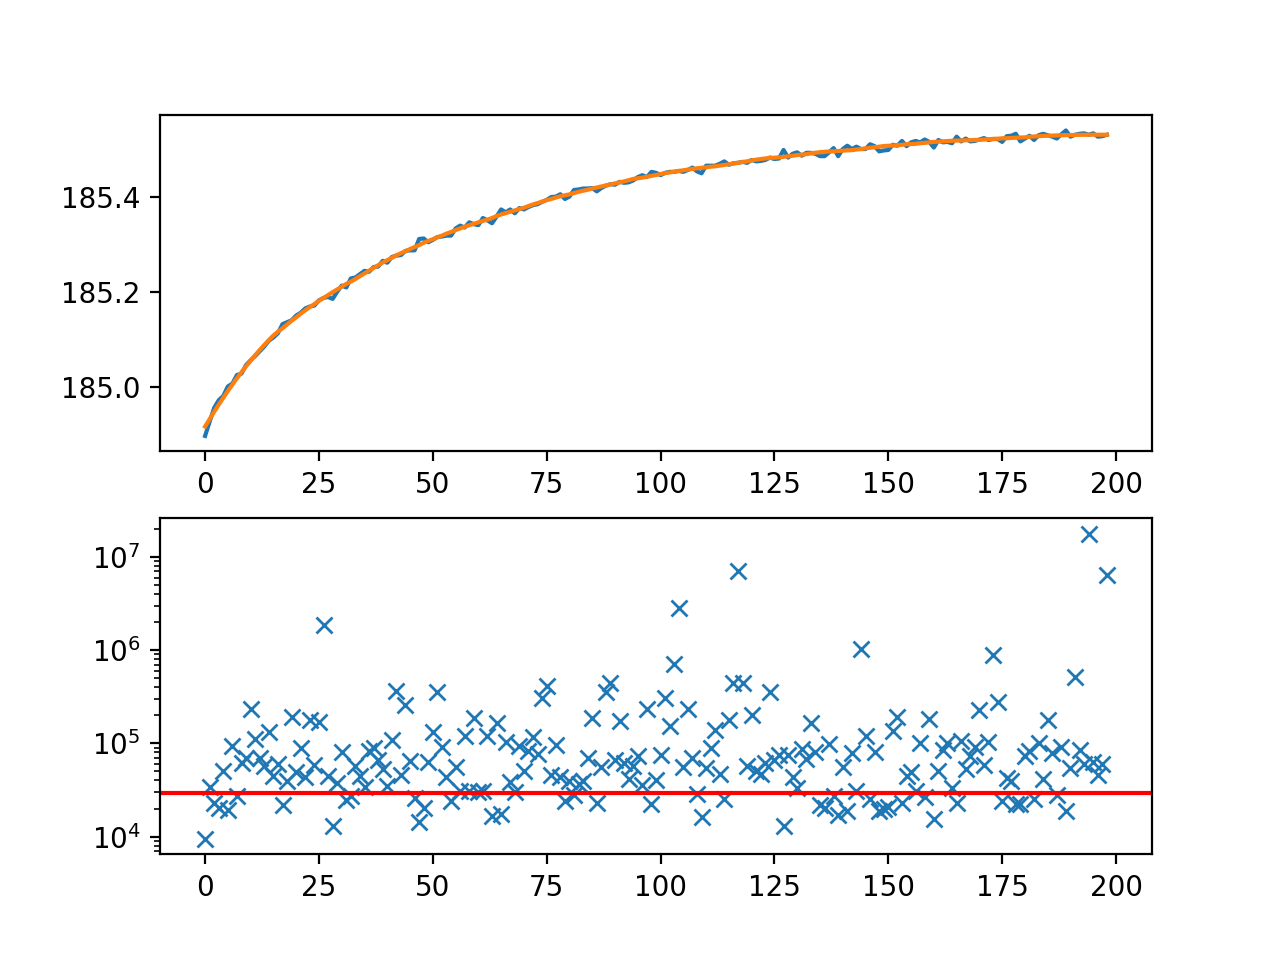

SNR for initial transiens is 2.9e+04


In [26]:
stop = 293

average_spectra(File.path, dT = 0.3, save = True)

* SNR $\propto$ round
* SNR $\propto$ $\sqrt{N}$
* SNR $\propto$ ???

In [ ]:
T = np.asmatrix([314,315,316])
print(T.shape)
C = np.asmatrix([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
C = C.T
print(C.shape)
Z = np.zeros(T.T.shape)
print(Z.shape)
D = np.append(T.T, Z, axis = 1)
D = np.append(D, C.T, axis = 1)
D = np.append(D, Z, axis = 1)
D = np.append(D, Z, axis = 1)
print(D)